# _*Reinforcement Learning and Dynamic Optimization*_
## Project 2: Stock Market Trading Phase 2 (2024)
---
### Students Info
---
##### ID : 2020030055
##### Full Name : Georgios - Marios Tsikritzakis
---
##### ID : 2020030137
##### Full Name : Vasileios Koutsovasilis
---

#Task 1

## Environment Set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

"""*********************** ENVIRONMENT *********************** """

N = 3                         # Number of stocks
c = 0.05                      # Transaction fee
gamma = 0.95                  # Discount factor gamma
episodes = 10000              # Number of episodes for training
alpha = 0.1                   # Learning rate
epsilon = 1.0                 # Initial exploration rate
epsilon_decay = 0.001         # Decay rate for epsilon.Epsilon is decreased as e/(1+e_decay*episode_num)
max_steps_per_episode = 100   # Maximum number of steps per episode

# Expected gains
r_H = [0.1, 0.06, 0.04]       # Gains in state H for each stock
r_L = [0.01, -0.02, 0.03]     # Gains in state L for each stock

# Transition probabilities
P_HH = [0.9, 0.85, 0.8]       # Transition probabilities for HH
P_HL = [0.1, 0.15, 0.2]       # Transition probabilities for HL
P_LH = [0.1, 0.2, 0.25]       # Transition probabilities for LH
P_LL = [0.9, 0.8, 0.75]       # Transition probabilities for LL

# Define states
states = [(chosen_stock,) + tuple(s) for chosen_stock in range(N) for s in np.ndindex((2,)*N)]
state_indices = {state: i for i, state in enumerate(states)}
num_states = len(states)

# Define actions
actions = range(N)

# Initialize Q-table
q_table = np.zeros((num_states, len(actions)))

# Reward function R(s,a,s')
def reward(state, action, next_state):
    current_stock = state[0]
    next_stock_state = next_state[action + 1]
    if current_stock != action:
        return -c + (r_H[action] if next_stock_state == 1 else r_L[action])
    else:
        return r_H[action] if next_stock_state == 1 else r_L[action]

# Transition probability function
def transition_probability(current_state, action, next_state):
    if action != next_state[0]: return 0
    _, *current_states = current_state
    _, *next_states = next_state
    prob = 1.0
    for i in range(N):
        if current_states[i] == 1:
            prob *= P_HH[i] if next_states[i] == 1 else P_HL[i]
        else:
            prob *= P_LL[i] if next_states[i] == 0 else P_LH[i]
    return prob


## Tabular Q learning Algorithm

Training completed.
Learned Q-table:
[[0.94175074 0.89983004 1.00057055]
 [0.94689975 0.9191147  1.04888165]
 [0.94550239 0.94416571 1.01892088]
 [0.946019   0.93843977 1.02071818]
 [1.21557994 1.118897   1.13060985]
 [1.28960129 1.08118093 1.12582045]
 [1.25717334 1.10957951 1.12143669]
 [1.22674096 1.1245684  1.11596629]
 [0.92714619 0.92670632 1.02819037]
 [0.94081154 0.94494488 1.0237922 ]
 [0.96627185 0.96749628 0.99618151]
 [0.95466742 1.04485368 0.97437851]
 [1.23161861 1.10899713 1.10561112]
 [1.24940095 1.12676914 1.12493685]
 [1.11193551 1.18233823 1.10812238]
 [1.25379954 1.11078566 1.1262939 ]
 [0.91650739 0.93704516 1.05520138]
 [0.96922417 0.94418316 1.11639193]
 [0.94406401 0.97615914 1.08617528]
 [0.94415308 0.97000094 1.10931899]
 [1.21272643 1.05294207 1.09585133]
 [1.25369222 1.08671745 1.10904535]
 [1.19928192 1.08709525 1.09278969]
 [1.23901096 1.10143765 1.12207195]]


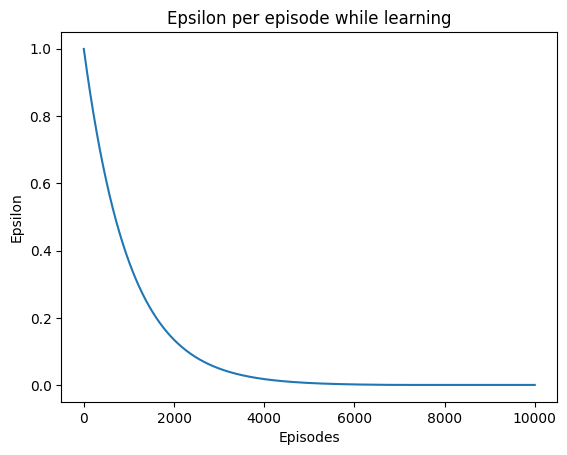

In [2]:

"""*********************** AGENT *********************** """
# Choose an action using epsilon-greedy policy
def choose_action(state, q_table, epsilon):
    choice = np.random.choice([0, 1], p=[epsilon, 1-epsilon])
    if choice == 0:
        return np.random.choice(actions)
    else:
        state_index = state_indices[state]
        return np.argmax(q_table[state_index])

# Simulates one step in the environment
def step(state, action):
    next_state_probabilities = []
    for next_state in states:
        prob = transition_probability(state, action, next_state)
        if prob > 0:
            next_state_probabilities.append((next_state, prob))

    if not next_state_probabilities:
        return state, 0  # No valid next state

    next_states, probs = zip(*next_state_probabilities) # unpack states , probs to seperate iterables.
    next_state = random.choices(next_states, probs)[0]
    reward_value = reward(state, action, next_state)
    return next_state, reward_value


# Train the agent using Q-learning
epsilon_history = []

for episode in range(episodes):
    state = random.choice(states)
    steps = 0
    while steps < max_steps_per_episode:
        # Choose action using e-greedy policy:
        action = choose_action(state, q_table, epsilon)

        # Observe R, S'
        next_state, reward_value = step(state, action)
        state_index = state_indices[state]
        next_state_index = state_indices[next_state]

        # Update Q table:
        best_next_action = np.argmax(q_table[next_state_index])
        td_target = reward_value + gamma * q_table[next_state_index][best_next_action]
        td_error = td_target - q_table[state_index][action]
        q_table[state_index][action] += alpha * td_error

        state = next_state
        steps += 1

    epsilon = max(0.001, epsilon * np.exp(-epsilon_decay)) # decrease epsilon with each passing episode
    epsilon_history.append(epsilon)

plt.figure()
plt.plot(epsilon_history)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon per episode while learning')


print("Training completed.")
print("Learned Q-table:")
print(q_table)

## Simulation

In [3]:
def test_policy(q_table):
    for state in states:
        state_index = state_indices[state]
        curr_state = state
        action = np.argmax(q_table[state_index])
        curr_stock = state[0] + 1
        l = list(curr_state)
        new_l = [str(i+1) + str("H" if s else "L") for i,s in enumerate(l[1:])]
        new_l.insert(0, curr_stock)
        print(f"Current State: {new_l}, Action: {action + 1}")

print("Testing the learned policy:")
test_policy(q_table)

Testing the learned policy:
Current State: [1, '1L', '2L', '3L'], Action: 3
Current State: [1, '1L', '2L', '3H'], Action: 3
Current State: [1, '1L', '2H', '3L'], Action: 3
Current State: [1, '1L', '2H', '3H'], Action: 3
Current State: [1, '1H', '2L', '3L'], Action: 1
Current State: [1, '1H', '2L', '3H'], Action: 1
Current State: [1, '1H', '2H', '3L'], Action: 1
Current State: [1, '1H', '2H', '3H'], Action: 1
Current State: [2, '1L', '2L', '3L'], Action: 3
Current State: [2, '1L', '2L', '3H'], Action: 3
Current State: [2, '1L', '2H', '3L'], Action: 3
Current State: [2, '1L', '2H', '3H'], Action: 2
Current State: [2, '1H', '2L', '3L'], Action: 1
Current State: [2, '1H', '2L', '3H'], Action: 1
Current State: [2, '1H', '2H', '3L'], Action: 2
Current State: [2, '1H', '2H', '3H'], Action: 1
Current State: [3, '1L', '2L', '3L'], Action: 3
Current State: [3, '1L', '2L', '3H'], Action: 3
Current State: [3, '1L', '2H', '3L'], Action: 3
Current State: [3, '1L', '2H', '3H'], Action: 3
Current Stat

## Testing Tabular Q-Learning for question 1 of assignment 3 scenario(Stay in the current stock)

Training completed.
Learned Q-table:
[[ 0.01911941 -0.80418385]
 [ 0.01228352 -0.77018316]
 [ 0.07310954 -0.81328137]
 [ 0.06819009 -0.77634378]
 [-0.78369333 -0.00129294]
 [-0.78648763  0.02857552]
 [-0.73745188 -0.01076753]
 [-0.72339189  0.03174944]]

Testing the learned policy:

Current State: [1, '1L', '2L'], Action: 1
Current State: [1, '1L', '2H'], Action: 1
Current State: [1, '1H', '2L'], Action: 1
Current State: [1, '1H', '2H'], Action: 1
Current State: [2, '1L', '2L'], Action: 2
Current State: [2, '1L', '2H'], Action: 2
Current State: [2, '1H', '2L'], Action: 2
Current State: [2, '1H', '2H'], Action: 2


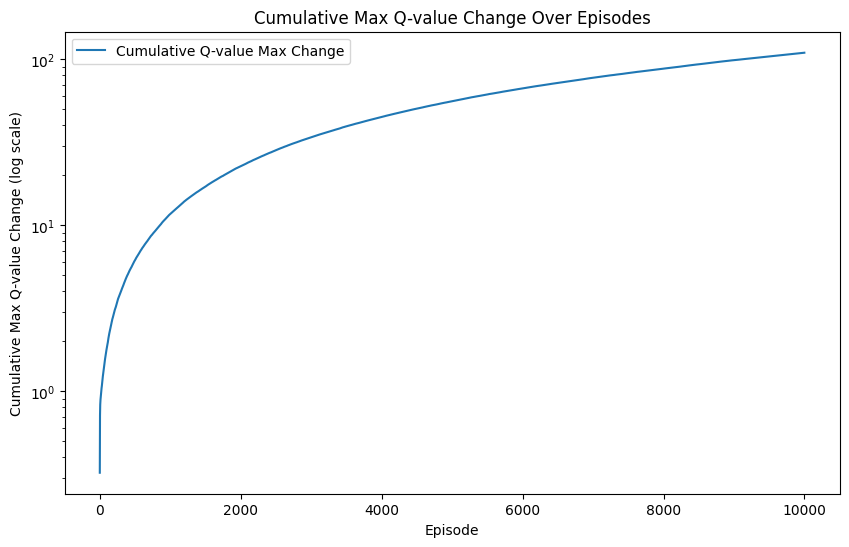

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
N = 2                         # Number of stocks
c = 0.8                       # Transaction fee
gamma = 0                     # Discount factor gamma
episodes = 10000              # Number of episodes for training
alpha = 0.1                   # Learning rate
epsilon = 1.0                 # Initial exploration rate
epsilon_decay = 0.001         # Decay rate for epsilon.Epsilon is decreased as epsilon * e^-decay
max_steps_per_episode = 100   # Maximum number of steps per episode


# Expected gains
r2_H = 0.04
r1_H = 2*r2_H
r_H = [r1_H, r2_H]  # Gains in state H for each stock
r_L = [0.01, -0.02]  # Gains in state L for each stock


# Transition probabilities
P_HH = [0.9, 0.85]
P_HL = [0.1, 0.15]
P_LH = [0.1, 0.2]
P_LL = [0.9, 0.8]

"""
Semiography of the states as in the pdf:
(2,1,0,0) == {2 , (1H , 2L , 3L) }
"""


# Define states
states = [(chosen_stock,) + tuple(s) for chosen_stock in range(N) for s in np.ndindex((2,)*N)]
state_indices = {state: i for i, state in enumerate(states)}
num_states = len(states)

# Define actions
actions = range(N)

# Initialize Q-table
q_table = np.zeros((num_states, len(actions)))

# Reward function R(s,a,s')
def reward(state, action, next_state):
    current_stock = state[0]
    next_stock_state = next_state[action + 1]
    if current_stock != action:
        return -c + (r_H[action] if next_stock_state == 1 else r_L[action])
    else:
        return r_H[action] if next_stock_state == 1 else r_L[action]


# Transition probability function
def transition_probability(current_state, action, next_state):
    if action != next_state[0]: return 0

    _, *current_states = current_state
    _, *next_states = next_state
    prob = 1.0
    for i in range(N):
        if current_states[i] == 1:
            prob *= P_HH[i] if next_states[i] == 1 else P_HL[i]
        else:
            prob *= P_LL[i] if next_states[i] == 0 else P_LH[i]
    return prob



# Train the agent using Q-learning
cumulative_q_changes = []
cumulative_change = 0
for episode in range(episodes):
    state = random.choice(states)
    steps = 0
    while steps < max_steps_per_episode:
        # Choose action using e-greedy policy:
        action = choose_action(state, q_table, epsilon)

        # Observe R, S'
        next_state, reward_value = step(state, action)
        state_index = state_indices[state]
        next_state_index = state_indices[next_state]

        # Update Q table:
        best_next_action = np.argmax(q_table[next_state_index])
        td_target = reward_value + gamma * q_table[next_state_index][best_next_action]
        td_error = td_target - q_table[state_index][action]
        q_table[state_index][action] += alpha * td_error

        state = next_state
        steps += 1

    epsilon = max(0.001, epsilon * np.exp(-epsilon_decay)) # decrease epsilon with each passing episode
    if episode > 0:
        q_change = np.abs(q_table - prev_q_table).max()
        cumulative_change += q_change
        cumulative_q_changes.append(cumulative_change)
    prev_q_table = q_table.copy()


print("Training completed.")
print("Learned Q-table:")
print(q_table)

print("\nTesting the learned policy:\n")
test_policy(q_table)

# Plotting the cumulative Q-value changes
plt.figure(figsize=(10, 6))
plt.plot(cumulative_q_changes, label='Cumulative Q-value Max Change')
plt.yscale('log')
plt.xlabel('Episode')
plt.ylabel('Cumulative Max Q-value Change (log scale)')
plt.title('Cumulative Max Q-value Change Over Episodes')
plt.legend()
plt.show()


## Testing Tabular Q-Learning for question 2 of assignment 3 scenario(in some states to switch and in some to stay)

Training completed.
Learned Q-table:
[[0.24173107 0.26323512]
 [0.2778071  0.30194585]
 [0.45684131 0.36765638]
 [0.52748498 0.36880409]
 [0.21315943 0.2961229 ]
 [0.28596679 0.37765292]
 [0.44600068 0.36791941]
 [0.45060003 0.37087665]]

Testing the learned policy:

Current State: [1, '1L', '2L'], Action: 2
Current State: [1, '1L', '2H'], Action: 2
Current State: [1, '1H', '2L'], Action: 1
Current State: [1, '1H', '2H'], Action: 1
Current State: [2, '1L', '2L'], Action: 2
Current State: [2, '1L', '2H'], Action: 2
Current State: [2, '1H', '2L'], Action: 1
Current State: [2, '1H', '2H'], Action: 1


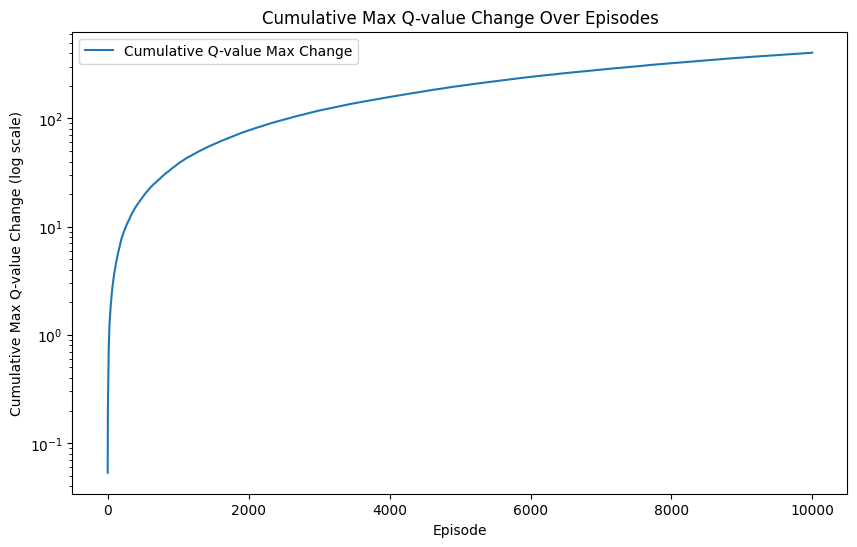

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
N = 2                         # Number of stocks
c = 0.05                      # Transaction fee
gamma = 0.9                   # Discount factor gamma
episodes = 10000              # Number of episodes for training
alpha = 0.1                   # Learning rate
epsilon = 1.0                 # Initial exploration rate
epsilon_decay = 0.001         # Decay rate for epsilon.Epsilon is decreased as e/(1+e_decay*episode_num)
max_steps_per_episode = 100   # Maximum number of steps per episode

# Expected gains
r2_H = 0.04
r1_H = 2*r2_H
r_H = [r1_H, r2_H]  # Gains in state H for each stock
r_L = [-0.01, 0.01]  # Gains in state L for each stock


# Transition probabilities
P_HH = [0.9, 0.85]
P_HL = [0.1, 0.15]
P_LH = [0.1, 0.2]
P_LL = [0.9, 0.8]

"""
Semiography of the states as in the pdf:
(2,1,0,0) == {2 , (1H , 2L , 3L) }
"""


# Define states
states = [(chosen_stock,) + tuple(s) for chosen_stock in range(N) for s in np.ndindex((2,)*N)]
state_indices = {state: i for i, state in enumerate(states)}
num_states = len(states)

# Define actions
actions = range(N)

# Initialize Q-table
q_table = np.zeros((num_states, len(actions)))

# Reward function R(s,a,s')
def reward(state, action, next_state):
    current_stock = state[0]
    next_stock_state = next_state[action + 1]
    if current_stock != action:
        return -c + (r_H[action] if next_stock_state == 1 else r_L[action])
    else:
        return r_H[action] if next_stock_state == 1 else r_L[action]


# Transition probability function
def transition_probability(current_state, action, next_state):
    if action != next_state[0]: return 0

    _, *current_states = current_state
    _, *next_states = next_state
    prob = 1.0
    for i in range(N):
        if current_states[i] == 1:
            prob *= P_HH[i] if next_states[i] == 1 else P_HL[i]
        else:
            prob *= P_LL[i] if next_states[i] == 0 else P_LH[i]
    return prob


# Train the agent using Q-learning
cumulative_q_changes = []
cumulative_change = 0
for episode in range(episodes):
    state = random.choice(states)
    steps = 0
    while steps < max_steps_per_episode:
        # Choose action using e-greedy policy:
        action = choose_action(state, q_table, epsilon)

        # Observe R, S'
        next_state, reward_value = step(state, action)
        state_index = state_indices[state]
        next_state_index = state_indices[next_state]

        # Update Q table:
        best_next_action = np.argmax(q_table[next_state_index])
        td_target = reward_value + gamma * q_table[next_state_index][best_next_action]
        td_error = td_target - q_table[state_index][action]
        q_table[state_index][action] += alpha * td_error

        state = next_state
        steps += 1

    epsilon = max(0.001, epsilon * np.exp(-epsilon_decay)) # decrease epsilon with each passing episode
    if episode > 0:
        q_change = np.abs(q_table - prev_q_table).max()
        cumulative_change += q_change
        cumulative_q_changes.append(cumulative_change)
    prev_q_table = q_table.copy()


print("Training completed.")
print("Learned Q-table:")
print(q_table)

print("\nTesting the learned policy:\n")
test_policy(q_table)

# Plotting the cumulative Q-value changes
plt.figure(figsize=(10, 6))
plt.plot(cumulative_q_changes, label='Cumulative Q-value Max Change')
plt.yscale('log')
plt.xlabel('Episode')
plt.ylabel('Cumulative Max Q-value Change (log scale)')
plt.title('Cumulative Max Q-value Change Over Episodes')
plt.legend()
plt.show()


# Task 2

In [6]:
import numpy as np
import random
import itertools

"""*********************** ENVIRONMENT *********************** """
N = 8                         # Number of stocks
gamma = 0.95                  # Discount factor gamma
episodes = 10000              # Number of episodes for training
alpha = 0.1                   # Learning rate
epsilon = 1.0                 # Initial exploration rate
epsilon_decay = 0.001         # Decay rate for epsilon
max_steps_per_episode = 100   # Maximum number of steps per episode
c = 0.05                      # Transaction fee


def generate_rewards(N):
    r_H = np.random.uniform(-0.02, 0.1, N)
    r_L = np.array([np.random.uniform(-0.02, r_H_i) for r_H_i in r_H])
    return r_H, r_L

# Generate rewards ensuring r_L < r_H for each stock
r_H, r_L = generate_rewards(N)

# Randomly assign transition probabilities
P_HL = np.array([0.1 if i < N // 2 else 0.5 for i in range(N)])
P_HH = 1 - P_HL
P_LH = np.array([0.5 if i < N // 2 else 0.1 for i in range(N)])
P_LL = 1 - P_LH

states = [(chosen_stock,) + tuple(s) for chosen_stock in range(N) for s in np.ndindex((2,)*N)]
print("States:\n")
print(states)
print("\n")
state_indices = {state: i for i, state in enumerate(states)}
num_states = len(states)
print(f"Number of states: {num_states}\n")

# Define actions
actions = range(N)

# Testing Environment Used for the Report
#r_H=[0.09191125, 0.00712202, 0.08180192, 0.0991868,  0.07771591, 0.09109335, 0.08568778, 0.07824772]
#r_L=[ 0.03969432, -0.00729206,  0.05855026, 0.00179933,  0.07403611,  0.04170629, 0.05884049,  0.04389849]
#P_HH=[0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5]
#P_HL=[0.1, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5]
#P_LL=[0.5, 0.5, 0.5, 0.5, 0.9, 0.9, 0.9, 0.9]
#P_LH=[0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1]

# Initialize Q-table
q_table = np.zeros((num_states, len(actions)))



States:

[(0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 0, 0, 0, 1, 0), (0, 0, 0, 0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 0, 0, 1, 0, 0), (0, 0, 0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 0, 0, 1, 1, 0), (0, 0, 0, 0, 0, 0, 1, 1, 1), (0, 0, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 0, 1, 0, 0, 1), (0, 0, 0, 0, 0, 1, 0, 1, 0), (0, 0, 0, 0, 0, 1, 0, 1, 1), (0, 0, 0, 0, 0, 1, 1, 0, 0), (0, 0, 0, 0, 0, 1, 1, 0, 1), (0, 0, 0, 0, 0, 1, 1, 1, 0), (0, 0, 0, 0, 0, 1, 1, 1, 1), (0, 0, 0, 0, 1, 0, 0, 0, 0), (0, 0, 0, 0, 1, 0, 0, 0, 1), (0, 0, 0, 0, 1, 0, 0, 1, 0), (0, 0, 0, 0, 1, 0, 0, 1, 1), (0, 0, 0, 0, 1, 0, 1, 0, 0), (0, 0, 0, 0, 1, 0, 1, 0, 1), (0, 0, 0, 0, 1, 0, 1, 1, 0), (0, 0, 0, 0, 1, 0, 1, 1, 1), (0, 0, 0, 0, 1, 1, 0, 0, 0), (0, 0, 0, 0, 1, 1, 0, 0, 1), (0, 0, 0, 0, 1, 1, 0, 1, 0), (0, 0, 0, 0, 1, 1, 0, 1, 1), (0, 0, 0, 0, 1, 1, 1, 0, 0), (0, 0, 0, 0, 1, 1, 1, 0, 1), (0, 0, 0, 0, 1, 1, 1, 1, 0), (0, 0, 0, 0, 1, 1, 1, 1, 1), (0, 0, 0, 1, 0, 0, 0, 0, 0), (0, 0, 0, 1, 0, 0, 0, 0, 1), (0, 

## Train and Simulate the large environment

Training completed.
Learned Q-table:
[[1.00538808 0.         0.         ... 0.         0.         0.        ]
 [0.9852569  0.         0.         ... 0.         0.         0.        ]
 [0.97525653 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.35522358 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.38399443 0.         0.         ... 0.         0.         0.        ]]

*********************  ENVIRONMENT *********************

N = 8
r_H:[ 0.06986873  0.06887028  0.00235093  0.05750238  0.00043482 -0.00607098
  0.056497    0.01820377]
r_L:[ 0.02741988  0.06100059 -0.00088739 -0.01456672 -0.00211002 -0.00868378
  0.05110765 -0.0008598 ]
P_HH:[0.9 0.9 0.9 0.9 0.5 0.5 0.5 0.5]
P_HL:[0.1 0.1 0.1 0.1 0.5 0.5 0.5 0.5]
P_LL:[0.5 0.5 0.5 0.5 0.9 0.9 0.9 0.9]
P_LH:[0.5 0.5 0.5 0.5 0.1 0.1 0.1 0.1]

Testing the learned policy:

Current State: [1, '1L', '2L', '3L', '4L', '5L', '6L', '7L', '

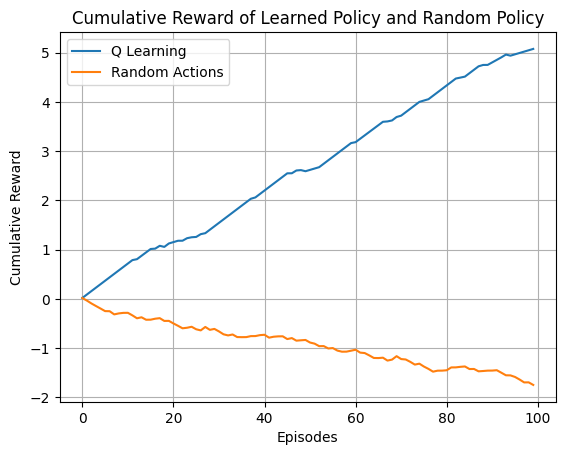

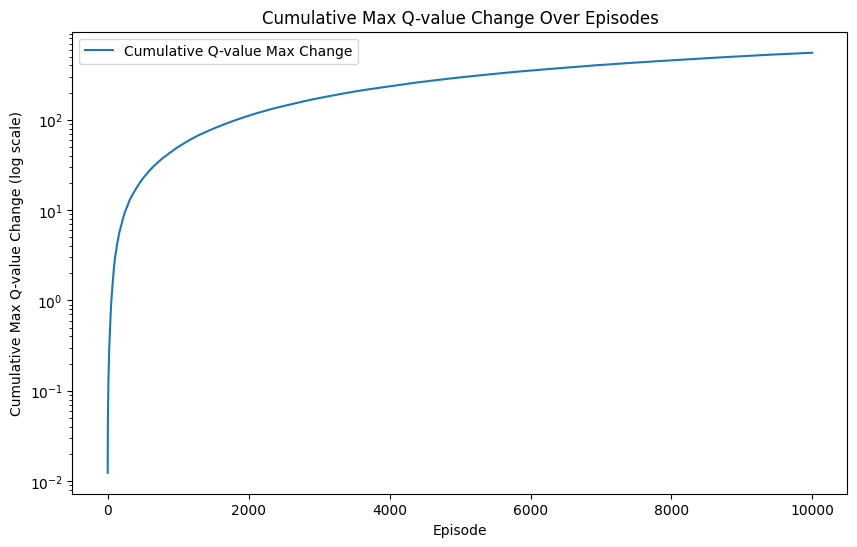

In [7]:
cumulative_q_changes = []
cumulative_change = 0
# Train the agent using Q-learning
for episode in range(episodes):
    state = random.choice(states)
    steps = 0
    while steps < max_steps_per_episode:
        # Choose action using e-greedy policy:
        action = choose_action(state, q_table, epsilon)
        # Observe R, S'
        next_state, reward_value = step(state, action)
        state_index = state_indices[state]
        next_state_index = state_indices[next_state]
        # Update Q table:
        best_next_action = np.argmax(q_table[next_state_index])
        td_target = reward_value + gamma * q_table[next_state_index][best_next_action]
        td_error = td_target - q_table[state_index][action]
        q_table[state_index][action] += alpha * td_error

        state = next_state
        steps += 1

    epsilon = max(epsilon/(1 + epsilon_decay*episode), 0.0001)
    if episode > 0:
        q_change = np.abs(q_table - prev_q_table).max()
        cumulative_change += q_change
        cumulative_q_changes.append(cumulative_change)
    prev_q_table = q_table.copy()

print("Training completed.")
print("Learned Q-table:")
print(q_table)

print("\n*********************  ENVIRONMENT *********************\n")
print(f"N = {N}")
print(f"r_H:{r_H}")
print(f"r_L:{r_L}")
print(f"P_HH:{P_HH}")
print(f"P_HL:{P_HL}")
print(f"P_LL:{P_LL}")
print(f"P_LH:{P_LH}")

print("\nTesting the learned policy:\n")

actions_taken = np.zeros((len(actions),)) # np array to hold the choice of stocks
for state in states:
    state_index = state_indices[state]
    curr_state = state
    action = np.argmax(q_table[state_index])
    actions_taken[action] += 1
    curr_stock = state[0] + 1
    l = list(curr_state)
    new_l = [str(i+1) + str("H" if s else "L") for i,s in enumerate(l[1:])]
    new_l.insert(0, curr_stock)
    print(f"Current State: {new_l}, Action: {action + 1}")

print(f"Stocks Chosen: { actions_taken}")
T = 100
cumulative_reward_QL = np.zeros((T,))
cumulative_reward_Random = np.zeros((T,))
state = random.choice(states)
random_state = state

# simulate for 100 steps in the environment starting from a random state
for i in range(T):
    action = np.argmax(q_table[state_indices[state]])
    random_action = np.random.choice(actions)
    next_state1, _reward1 = step(state, action)
    next_state2, _reward2 = step(random_state, random_action)
    if i != 0:
        cumulative_reward_QL[i] = cumulative_reward_QL[i-1] + _reward1
        cumulative_reward_Random[i] = cumulative_reward_Random[i-1] + _reward2
    else:
        cumulative_reward_QL[i] = _reward1
        cumulative_reward_Random[i] = _reward2
    state = next_state1
    random_state = next_state2

plt.figure()
plt.plot(cumulative_reward_QL)
plt.plot(cumulative_reward_Random)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward of Learned Policy and Random Policy")
plt.legend(["Q Learning", "Random Actions"])
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(cumulative_q_changes, label='Cumulative Q-value Max Change')
plt.yscale('log')
plt.xlabel('Episode')
plt.ylabel('Cumulative Max Q-value Change (log scale)')
plt.title('Cumulative Max Q-value Change Over Episodes')
plt.legend()
plt.show()

# Task 3

## Environment Setup

In [8]:
import numpy as np
import random
from collections import deque
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class StockTradingEnvironment:
    def __init__(self, N, r_H, r_L, P_HH, P_HL, P_LH, P_LL, c, gamma, alpha, epsilon, epsilon_decay, episodes, max_steps_per_episode, batch_size):
        self.N = N
        self.r_H = r_H
        self.r_L = r_L
        self.P_HH = P_HH
        self.P_HL = P_HL
        self.P_LH = P_LH
        self.P_LL = P_LL
        self.c = c
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.episodes = episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.current_state = np.zeros((self.N+1,)) # the current state is a 1x(N+1) vector where index 0 we have the current stock i and the rest are the stock prices
        initial_stock = np.random.randint(self.N)  # Randomly select an initial stock to invest in
        self.current_state[0] = initial_stock
        self.state_HL = np.random.choice([0, 1], size=self.N)  # Random initial states (0 for L, 1 for H)
        self.set_curr_rewards()
        self.previous_action = None
        self.batch_size = batch_size

    # function to set the stock prices for the state according to their High or Low values
    def set_curr_rewards(self):
        i = 1
        for j in range(N):
            self.current_state[i] = self.r_H[j] if self.state_HL[j] == 1 else self.r_L[j]
            i+=1

    # function to reset the environment
    def reset(self):
        self.current_state = np.zeros((self.N+1,))
        self.previous_action = None
        self.state_HL = np.random.choice([0, 1], size=self.N)  # Random initial states
        initial_stock = np.random.randint(self.N)  # Randomly select an initial stock to invest in
        self.current_state[0] = initial_stock
        self.set_curr_rewards()
        return self.current_state

    # the step function for a given action
    def step(self, action):
        reward = self._calculate_reward(action)
        self._update_state()
        next_state = self._get_state(action)
        return next_state, reward

    # function to calculate the reward given an action
    def _calculate_reward(self, action):
        current_yield = self.r_H[action] if self.state_HL[action] == 1 else self.r_L[action]
        reward = current_yield - (self.c if self.previous_action is not None and self.previous_action != action else 0)
        self.previous_action = action
        return reward

    # function to update the state highs and lows (used after a step was taken)
    def _update_state(self):
        for i in range(self.N):
            if self.state_HL[i] == 1:
                self.state_HL[i] = np.random.choice([1, 0], p=[self.P_HH[i], self.P_HL[i]])
            else:
                self.state_HL[i] = np.random.choice([1, 0], p=[self.P_LH[i], self.P_LL[i]])

    # function to get the state given an action in the correct format
    def _get_state(self, action):
        state = np.zeros((self.N+1,))
        state[0] = action
        i = 1
        for j in range(N):
            state[i] = self.r_H[j] if self.state_HL[j] == 1 else self.r_L[j]
            i+=1
        return state

    # function to set the current state to the given one
    def set_current_state(self, state):
        self.current_state = state



## DQN and Replay Memory for training

In [9]:

class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

# Replay Memory to store tuples of (s,a,s',r) to use in the optimization part
class ReplayMemory:
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    # function to add a new item to the buffer
    def append(self, transition):
        self.memory.append(transition)

    # function that returns a random sample from memory buffer
    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)


## Agent (basic training algorithm)

In [10]:

class StockTradingDQL:
    def __init__(self, env):
        self.env = env
        self.policy_dqn = DQN(in_states=self.env.N+1, h1_nodes=64, out_actions=self.env.N) # policy NN
        self.target_dqn = DQN(in_states=self.env.N+1, h1_nodes=64, out_actions=self.env.N) # target NN
        self.target_dqn.load_state_dict(self.policy_dqn.state_dict()) # Make the Target network a copy of the policy network
        self.optimizer = torch.optim.Adam(self.policy_dqn.parameters(), lr=self.env.alpha) # use the Adam optimizer
        self.loss_fn = nn.MSELoss() # Loss function is the MSE
        self.memory = ReplayMemory(1000)
        self.epsilon = self.env.epsilon
        self.epsilon_decay = self.env.epsilon_decay
        self.gamma = self.env.gamma
        self.alpha = self.env.alpha
        self.batch_size = self.env.batch_size

    def train(self):
        rewards_per_episode = np.zeros(self.env.episodes)
        epsilon_history = []
        step_count = 0
        for i in range(self.env.episodes):
            print(f'Episode {i+1}/{self.env.episodes}')
            state = self.env.reset() # start from a random state
            total_reward = 0

            for _ in range(self.env.max_steps_per_episode):
                # choose an action based on the epsilon greedy algorithm
                if random.random() < self.epsilon:
                    action = np.random.randint(self.env.N)
                else:
                    with torch.no_grad():
                        action = self.policy_dqn(torch.FloatTensor(state)).argmax().item()
                # make a step in the environment to get the S', R
                next_state, reward = self.env.step(action)
                total_reward += reward
                # add the (s,a,s',r) to the memory buffer
                self.memory.append((state, action, next_state, reward))

                # if memory has at least batch size entries optimize
                if len(self.memory) > self.batch_size:
                    self.optimize_model()

                state = next_state
                # set the current state in the environment to the next state
                self.env.set_current_state(next_state)

            rewards_per_episode[i] = total_reward
            self.epsilon = max(self.epsilon * self.epsilon_decay, 0.01) # decrease epsilon exponentially after each episode
            epsilon_history.append(self.epsilon)
            # Every 10 episodes sync the target and policy dqn
            if step_count > 10:
                self.target_dqn.load_state_dict(self.policy_dqn.state_dict())
                step_count = 0
            step_count += 1

        self.plot_results(rewards_per_episode, epsilon_history)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        mini_batch = self.memory.sample(self.batch_size) # get a sample from memory of batch_size entries
        current_qs, target_qs = [], []

        for state, action, next_state, reward in mini_batch:
          # calculate the target Q value based on formula TD_target = R + gamma*max(Q(s',a))
            with torch.no_grad():
                target_q = reward + self.gamma * self.target_dqn(torch.FloatTensor(next_state)).max().item()

            # calculate the current q values
            current_q = self.policy_dqn(torch.FloatTensor(state))
            current_qs.append(current_q)

            # calculate the target q values
            target_q_vec = current_q.clone().detach()
            # set the target value of the action to the one calculated by the TD_target equation
            target_q_vec[action] = target_q
            target_qs.append(target_q_vec)

        # compute the loss for the mini batch and backward propagate
        loss = self.loss_fn(torch.stack(current_qs), torch.stack(target_qs))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_results(self, rewards_per_episode, epsilon_history):
        plt.figure()
        plt.plot(rewards_per_episode)
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title('Total Reward per episode while learning')

        plt.figure()
        plt.plot(epsilon_history)
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.title('Epsilon per episode while learning')

        plt.savefig('stock_trading_dql.png')

    # function to turn a state into a tensor to be viable as input to the NN
    def state_to_dqn_input(self, stock_index, num_stocks):
        state = env._get_state(stock_index)
        input_tensor = torch.FloatTensor(state)
        return input_tensor

    # function to test the policy
    def test_policy(self, policy_dqn, num_stocks):
        cumulative_reward = np.zeros((100,))
        print("Testing Policy:")
        print(f"Simulating {100} days...")
        policy_dqn.eval() # switch the NN from training mode to evaluation mode
        state = self.env.reset()
        random_state = state
        total_reward = 0  # Initialize total reward accumulator
        for i in range(100):
            stock = int(state[0])  # Extract the current stock index from state
            current_rewards = self.env.state_HL
            with torch.no_grad():
                action = policy_dqn(torch.FloatTensor(state)).argmax().item()
            next_state, reward = self.env.step(action)
            total_reward += reward  # Accumulate the reward
            cumulative_reward[i] = total_reward
            self.env.set_current_state(next_state)
            next_rewards = self.env.state_HL
            print(f"Day {i+1}: Stock {stock}, Current Stock Rewards: {current_rewards}, Action: {action}, Next Stock Rewards: {next_rewards}, Reward: {reward}")
            state = next_state

        print(f"Total reward accumulated over 100 days: {total_reward}")
        return cumulative_reward


## Simulation test

### Test the scenario of question 1 Assignment 3(Stay in the stock you are)

In [ ]:
def test_q1_ass3_policy( policy_dqn, num_stocks, env):
    print("Testing Policy:")
    policy_dqn.eval() # switch the NN from training mode to evaluation mode
    for j in range(2):
      state = env.reset()
      state[0] = 0 if j == 0 else 1
      total_reward = 0  # Initialize total reward accumulator
      for i in range(10):
          stock = int(state[0])  # Extract the current stock index from state
          current_rewards = env.state_HL
          with torch.no_grad():
            action = policy_dqn(torch.FloatTensor(state)).argmax().item()
          next_state, reward = env.step(action)
          total_reward += reward  # Accumulate the reward
          env.set_current_state(next_state)
          next_rewards = env.state_HL
          print(f"Day {i+1}: Stock {stock}, Current Stock Rewards: {current_rewards}, Action: {action}, Next Stock Rewards: {next_rewards}, Reward: {reward}")
          state = next_state

    print(f"Total reward accumulated over 100 days: {total_reward}")
# Define parameters
episodes = 100
alpha = 0.01
epsilon = 1.0
epsilon_decay = 0.95
max_steps_per_episode = 100
batch_size = 64
N = 2         # Number of stocks
c = 0.8      # Transaction fee
gamma = 0  # Discount factor gamma

# Expected gains
r2_H = 0.04
r1_H = 2*r2_H
r_H = [r1_H, r2_H]  # Gains in state H for each stock
r_L = [0.01, -0.02]  # Gains in state L for each stock


# Transition probabilities
P_HH = [0.9, 0.85]
P_HL = [0.1, 0.15]
P_LH = [0.1, 0.2]
P_LL = [0.9, 0.8]

env = StockTradingEnvironment(N, r_H, r_L, P_HH, P_HL, P_LH, P_LL, c, gamma, alpha, epsilon, epsilon_decay, episodes, max_steps_per_episode , batch_size)
agent = StockTradingDQL(env)
agent.train()

test_q1_ass3_policy(agent.policy_dqn, N, env)

Episode 1/100


KeyboardInterrupt: 

## Test the scenario of question 3 of assignment 3


*********************  ENVIRONMENT *********************

N = 8
r_H:[ 0.08795827  0.09910459 -0.01817261  0.06413952  0.0793927  -0.01069876
  0.09425293  0.01613537]
r_L:[ 0.05146962  0.0158788  -0.01936448  0.01840599  0.07827952 -0.01728453
  0.00771114  0.00953744]
P_HH:[0.9 0.9 0.9 0.9 0.5 0.5 0.5 0.5]
P_HL:[0.1 0.1 0.1 0.1 0.5 0.5 0.5 0.5]
P_LL:[0.5 0.5 0.5 0.5 0.9 0.9 0.9 0.9]
P_LH:[0.5 0.5 0.5 0.5 0.1 0.1 0.1 0.1]


Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39

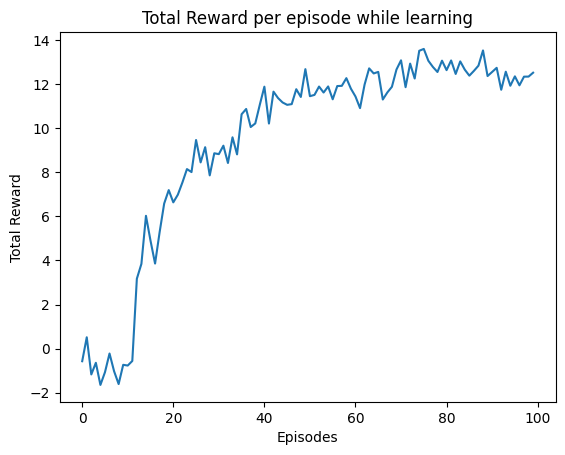

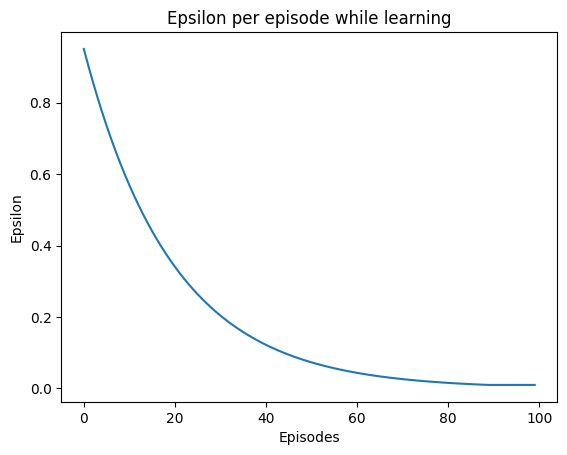

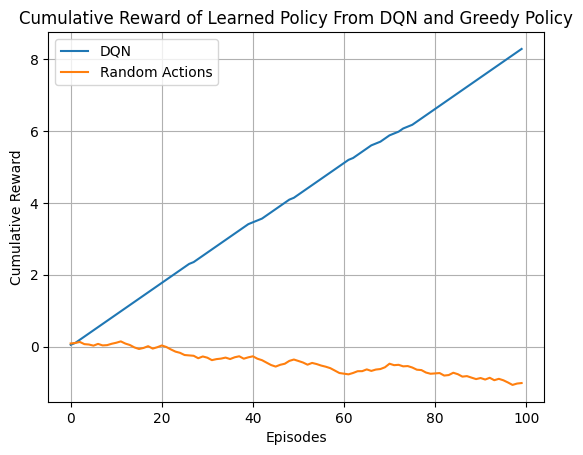

In [11]:
N = 8
gamma = 0.95
episodes = 100
alpha = 0.01
epsilon = 1.0
epsilon_decay = 0.95
max_steps_per_episode = 150
c = 0.05
batch_size = 64

def generate_rewards(N):
  r_H = np.random.uniform(-0.02, 0.1, N)
  r_L = np.array([np.random.uniform(-0.02, r_H_i) for r_H_i in r_H])
  return r_H, r_L

r_H, r_L = generate_rewards(N)

P_HL = np.array([0.1 if i < N // 2 else 0.5 for i in range(N)])
P_HH = 1 - P_HL
P_LH = np.array([0.5 if i < N // 2 else 0.1 for i in range(N)])
P_LL = 1 - P_LH

# Testing environment used for the Report
#r_H=[0.09191125, 0.00712202, 0.08180192, 0.0991868,  0.07771591, 0.09109335, 0.08568778, 0.07824772]
#r_L=[ 0.03969432, -0.00729206,  0.05855026, 0.00179933,  0.07403611,  0.04170629, 0.05884049,  0.04389849]
#P_HH=[0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5]
#P_HL=[0.1, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5]
#P_LL=[0.5, 0.5, 0.5, 0.5, 0.9, 0.9, 0.9, 0.9]
#P_LH=[0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1]

print("\n*********************  ENVIRONMENT *********************\n")
print(f"N = {N}")
print(f"r_H:{r_H}")
print(f"r_L:{r_L}")
print(f"P_HH:{P_HH}")
print(f"P_HL:{P_HL}")
print(f"P_LL:{P_LL}")
print(f"P_LH:{P_LH}\n\n")

env = StockTradingEnvironment(N, r_H, r_L, P_HH, P_HL, P_LH, P_LL, c, gamma, alpha, epsilon, epsilon_decay, episodes, max_steps_per_episode , batch_size)
agent = StockTradingDQL(env)
agent.train()

cumulative_reward = agent.test_policy(agent.policy_dqn, N)
random_cumulative_reward = np.zeros((100,))
state = env.reset()
total_reward = 0
actions = range(N)
for i in range(100):
    random_action = np.random.choice(actions)
    next_state, _reward = env.step(random_action)
    total_reward += _reward
    random_cumulative_reward[i] = total_reward
    state = next_state
    env.set_current_state(next_state)

plt.figure()
plt.plot(cumulative_reward)
plt.plot(random_cumulative_reward)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward of Learned Policy From DQN and Greedy Policy")
plt.legend(["DQN", "Random Actions"])
plt.grid()
plt.show()